# Data reduction and 3D analysis


In this tutorial, we present the basics steps for a 3D stacked analysis. The main aim is to perform a spectral and morphological analysis of a given source. We are going to analyse the data from the High Energy Stereoscopic System (H.E.S.S.) towards the SNR RX J1713.7-3946. 

Let's start with some basic imports:

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
import numpy as np

from gammapy.data import DataStore
from gammapy.datasets import MapDataset, Datasets
from gammapy.estimators import ExcessMapEstimator
from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)

In [2]:
data_store = DataStore.from_dir(f"$GAMMAPY_DATA/hess-dl3-dr1")

Lets look at the information for that datastore.

In [3]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/feijen/gammapy-datasets/1.2/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



In [4]:
target_position = SkyCoord.from_name("RX J1713.7-3946").galactic

### What are the galactic coordinates of this source?

In [5]:
print(target_position)

<SkyCoord (Galactic): (l, b) in deg
    (347.26945653, -0.25689328)>


We can now define an observation filter to select only the relevant observations. Here we use a cone search which we define with a python dict.

We then filter the ObservationTable with `~gammapy.data.ObservationTable.select_observations()`.


In [6]:
selection = dict(
    type="sky_circle",
    frame='galactic',
    lon=target_position.l,
    lat=target_position.b,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

### Look at what is in that selected table

In [7]:
selected_obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20326,259.29852,-39.762222,347.74036,-1.0417831,18.712194,71.2878,154.81943,RXJ 1713.7-3946,258.3879,-39.762222,0.6999909,1683.0,1500.009,0.891271,103858277.0,103859960.0,2004-04-17,01:32:21.184,2004-04-17,02:00:24.184,4,"1,2,3,4",0,1.1412385,16880,RX J1713.7-3946,rxj1713,0.7252947,0.23442288,100.0
20327,257.47733,-39.762222,346.91946,0.092252225,16.734882,73.265114,173.0282,RXJ 1713.7-3946,258.3879,-39.762222,0.69996744,1683.0,1497.074,0.889527,103860109.0,103861792.0,2004-04-17,02:02:53.184,2004-04-17,02:30:56.184,4,"1,2,3,4",0,1.1392112,16995,RX J1713.7-3946,rxj1713,0.6746846,0.20417379,100.0
20349,259.29852,-39.762222,347.74036,-1.0417831,16.722466,73.277534,186.67764,RXJ 1713.7-3946,258.3879,-39.762222,0.6999909,1682.0,1494.5023,0.888527,103947504.0,103949186.0,2004-04-18,02:19:28.184,2004-04-18,02:47:30.184,4,"1,2,3,4",0,1.1592567,16141,RX J1713.7-3946,rxj1713,0.7252947,0.20417379,100.0
20350,257.47733,-39.762222,346.91946,0.092252225,18.658506,71.34149,204.89865,RXJ 1713.7-3946,258.3879,-39.762222,0.69996744,1682.0,1497.6545,0.890401,103949330.0,103951012.0,2004-04-18,02:49:54.184,2004-04-18,03:17:56.184,4,"1,2,3,4",0,1.1565586,16081,RX J1713.7-3946,rxj1713,0.6746846,0.23442288,100.0
20396,258.3879,-39.06222,347.8998,-0.062237248,16.931627,73.068375,190.61954,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1683.0,1499.001,0.89067197,104120195.0,104121878.0,2004-04-20,02:17:39.184,2004-04-20,02:45:42.184,4,"1,2,3,4",0,1.1642822,16418,RX J1713.7-3946,rxj1713,0.7092343,0.20417379,100.0
20397,258.3879,-40.462223,346.76566,-0.8830993,19.253716,70.746284,207.88188,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1682.0,1505.1713,0.89487,104122008.0,104123690.0,2004-04-20,02:47:52.184,2004-04-20,03:15:54.184,4,"1,2,3,4",0,1.1711123,15798,RX J1713.7-3946,rxj1713,0.691681,0.23442288,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20518,258.3879,-39.06222,347.8998,-0.062237248,16.80531,73.194695,171.5077,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1682.0,1506.199,0.895481,104463121.0,104464803.0,2004-04-24,01:33:05.184,2004-04-24,02:01:07.184,4,"1,2,3,4",0,1.1684012,14636,RX J1713.7-3946,rxj1713,0.7092343,0.20417379,100.0



We can now retrieve the relevant observations by passing their obs_id to the `~gammapy.data.DataStore.get_observations()` method.


In [8]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

### View those observations

In [9]:
print(observations)

Observations
Number of observations: 15
Observation

	obs id            : 20326 
 	tstart            : 53112.06
	tstop             : 53112.08
	duration          : 1683.00 s
	pointing (icrs)   : 259.3 deg, -39.8 deg

	deadtime fraction : 10.9%
Observation

	obs id            : 20327 
 	tstart            : 53112.09
	tstop             : 53112.10
	duration          : 1683.00 s
	pointing (icrs)   : 257.5 deg, -39.8 deg

	deadtime fraction : 11.0%
Observation

	obs id            : 20349 
 	tstart            : 53113.10
	tstop             : 53113.12
	duration          : 1682.00 s
	pointing (icrs)   : 259.3 deg, -39.8 deg

	deadtime fraction : 11.1%
Observation

	obs id            : 20350 
 	tstart            : 53113.12
	tstop             : 53113.14
	duration          : 1682.00 s
	pointing (icrs)   : 257.5 deg, -39.8 deg

	deadtime fraction : 11.0%
Observation

	obs id            : 20396 
 	tstart            : 53115.10
	tstop             : 53115.12
	duration          : 1683.00 s
	pointing (icrs

# Preparing reduced datasets geometry

We define a reference geometry for our analysis.

We choose a WCS based geometry. We define the center of the geometry by our target source, assign a binsize of 0.02 deg, the width of the geometry, and also define an energy axis.

This geometry will be what our final dataset will look like.

In [10]:
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 15, unit="TeV")

geom = WcsGeom.create(
    skydir=target_position,
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_axis],
)

Important: we have both a 'true' energy axis and 'reconstructed' energy axis. We must ensure that the true axis is both wider in energy and contains more bins than the 'reco'.

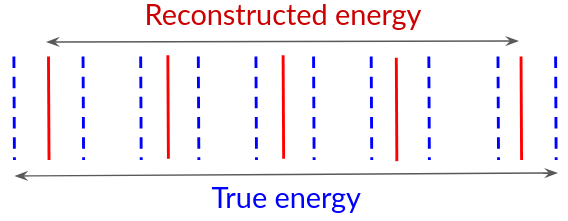

### Define the true energy axis based on the above information

In [11]:
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 20, unit="TeV", name="energy_true"
)

In [12]:
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (300, 300, 15)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 347.3 deg, -0.3 deg
	width      : 6.0 deg x 6.0 deg
	wcs ref    : 347.3 deg, -0.3 deg




# Data reduction - FoV background method!

Create the maker classes to be used

The `~gammapy.datasets.MapDatasetMaker` object is initialized as well as the `~gammapy.makers.SafeMaskMaker` that carries here a maximum offset selection.


In [13]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="rxj-stacked"
)

We need to mask out any sources with significant emission.

You can check the http://gamma-sky.net to see if there are sources in the FoV and create an exclusion region based that.

In [14]:
circle = CircleSkyRegion(center=target_position, radius=0.7*u.deg)
regions = [circle]
exclusion_mask = ~geom.region_mask(regions=regions)

## Try to plot the exclusion mask

In [15]:
exclusion_mask.plot_interactive()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

Create the `makers`.

In [16]:
maker = MapDatasetMaker(
    selection=["counts", "background", "psf", "edisp", "exposure"]
)
safe_mask_maker = SafeMaskMaker(
    methods=["offset-max", "aeff-max", "bkg-peak"], offset_max="2.3 deg"
)
fov_bkg_maker = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

### Perform the data reduction loop recalling the order:
- maker
- safe mask
- FoVbkg

In [17]:
for obs in observations:
    dataset = maker.run(stacked, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset = fov_bkg_maker.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    stacked.stack(dataset)

Background norm obs 20326: 1.05
Background norm obs 20327: 1.06
Background norm obs 20349: 1.00
Background norm obs 20350: 1.06
Background norm obs 20396: 1.01
Background norm obs 20397: 1.07
Background norm obs 20421: 1.07
Background norm obs 20422: 1.02
Background norm obs 20517: 1.01
Background norm obs 20518: 0.97
Background norm obs 20519: 1.00
Background norm obs 20521: 1.04
Background norm obs 20898: 1.14
Background norm obs 20899: 1.05
Background norm obs 20900: 0.99


In [18]:
print(stacked)

MapDataset
----------

  Name                            : rxj-stacked 

  Total counts                    : 74124 
  Total background counts         : 72027.48
  Total excess counts             : 2096.52

  Predicted counts                : 72027.47
  Predicted background counts     : 72027.48
  Predicted excess counts         : nan

  Exposure min                    : 3.54e+05 m2 s
  Exposure max                    : 6.48e+09 m2 s

  Number of total bins            : 1350000 
  Number of fit bins              : 1058640 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




We can save this file so that later you can manipulate it!

In [20]:
# stacked.write("stacked_MapDataset.fits")

We can also `peek` this, just like we did with the observations.

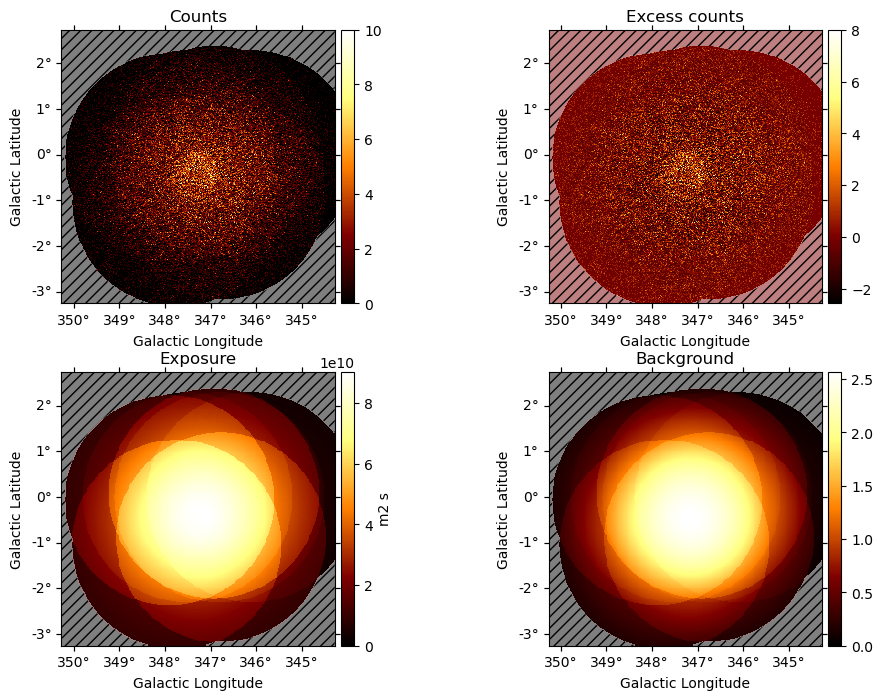

In [21]:
stacked.peek()

It looks like we have some source based on the counts image but it is hard to discern. This is because we have a map with very fine binning, so to view this better we can plot (for example) a counts map which has been smoothed.

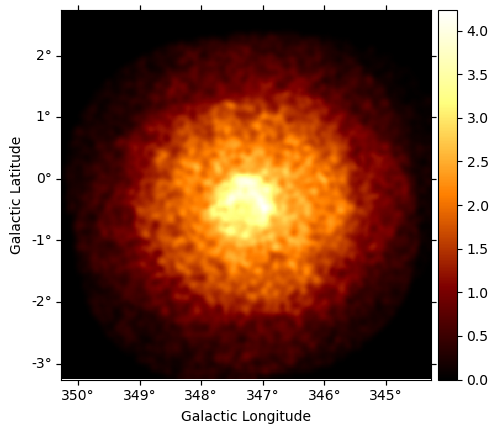

In [22]:
stacked.counts.reduce_over_axes().smooth(0.05 * u.deg).plot(add_cbar=True)
plt.show()

Note: in the about plot I utilised the `reduce_over_axes` functionality. If you print the shape of the `counts` object, you will see that we have a third axis in energy which has the same amount of bins as we first defined for our `geom`. This function will reduce the non-spatial axes of the map (i.e. the energy axis), such that it just has 1 bin and can be plotted as a 2D figure with the `plot` functionality.



## Compute an excess and a significance map

In [23]:
estimator = ExcessMapEstimator(
    0.1 * u.deg, selection_optional=[], energy_edges=[0.4, 20] * u.TeV
)
maps = estimator.run(stacked)

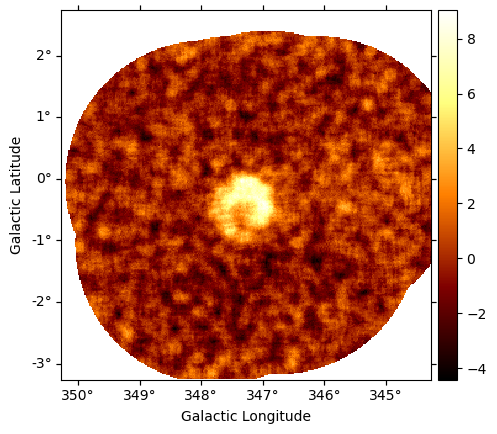

In [24]:
maps.sqrt_ts.plot(add_cbar=True)
plt.show()

### We can plot the excess and significance maps

<WCSAxes: title={'center': 'Excess map'}>

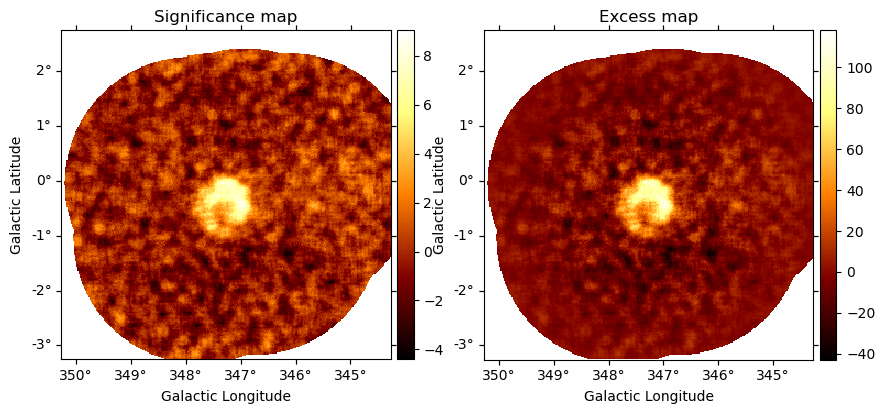

In [25]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=maps.sqrt_ts.geom.wcs)
ax2 = plt.subplot(222, projection=maps.sqrt_ts.geom.wcs)

ax1.set_title("Significance map")
maps.sqrt_ts.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
maps.npred_excess.plot(ax=ax2, add_cbar=True)

# Can you create a map for the flux now?

Recall: it is possible to have autocompletion suggestions. Try it yourself with writing `maps.` and then press crtl+space

/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<WCSAxes: >

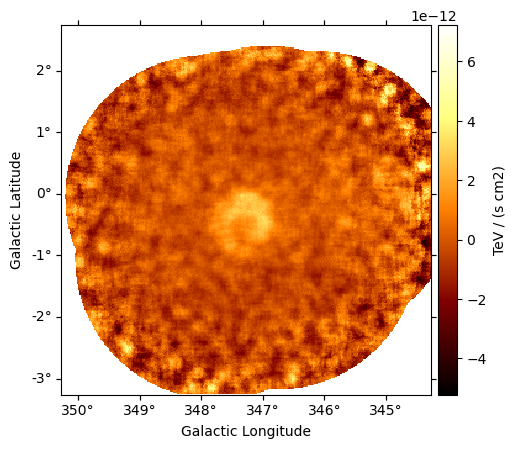

In [26]:
maps.eflux.plot(add_cbar=True)

# What about a map in different energy bins?

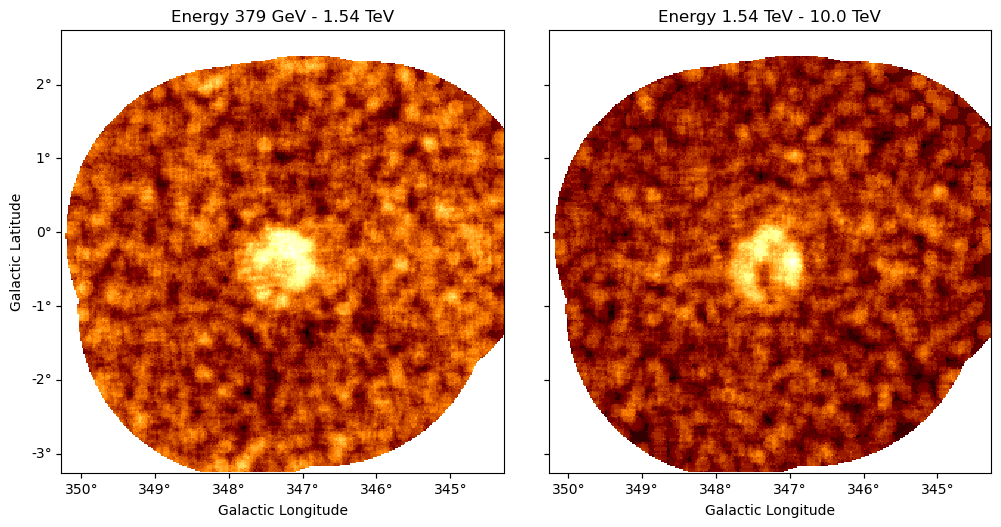

In [27]:
estimator2 = ExcessMapEstimator(0.1 * u.deg, selection_optional=[], energy_edges=[0.4, 1.5, 20]*u.TeV)
maps2 = estimator2.run(stacked)

maps2.sqrt_ts.plot_grid()
plt.show()

### Bonus: plot the exclusion mask on top of the image to ensure we excluded all significant emission from the background when we created the dataset

The exclusion mask was created based off a `region` so we can utilise its functionality to plot it. 

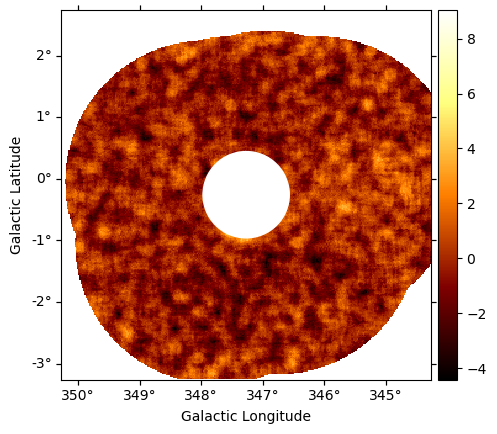

In [28]:
ax = maps.sqrt_ts.plot(add_cbar=True)

# First convert the circle to pixel coordinates based on the WCS of our map
region_pix = circle.to_pixel(ax.wcs)

# Then convert the region into an 'artist' which can be plot
# Include here any settings for the region, ie its color, fill style etc
artist = region_pix.as_artist(color='white', fill=True)

# Plot the artist
ax.add_artist(artist)

plt.show()

### Well done!! You have gone from DL3 data products to a DL4 dataset, which can be used for SCIENCE! 🥳


## Lets do some science!

# Exercises: 3D modeling - fit a model to our dataset


The 3D analysis consists of a simultaneous fit of the spectral and spatial parameters of one or multiple sources. Here, we focus only on a single source, centered at the coordinates l=347.269°, b=-0.257°. To perform the fit, we firstly need to define a model: we can try with a Gaussian morphology and a powerlaw spectral shape.

In [29]:
from gammapy.modeling.models import GaussianSpatialModel

In [30]:
spatial_model = GaussianSpatialModel(
    lon_0=target_position.l, lat_0=target_position.b, sigma=0.4*u.deg, frame='galactic',
)

### 1 - Show on the map that this is a suitable guess for the emission extension and position

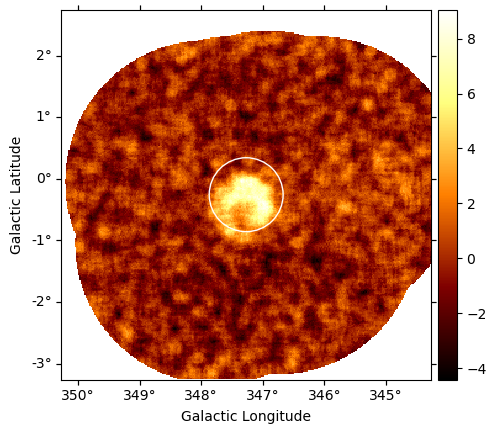

In [31]:
ax = maps.sqrt_ts.plot(add_cbar=True)
region = spatial_model.to_region().to_pixel(ax.wcs)
artist = region.as_artist(color='white')
ax.add_artist(artist)

plt.show()

### 2 - Create a spectral model, use a simple PowerLaw here. 

In [32]:
from gammapy.modeling.models import PowerLawSpectralModel

In [33]:
spectral_model = PowerLawSpectralModel(index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1*u.TeV)

We limit the model position inside a 1 deg box centered on the reference position of RX J1713

In [34]:
spatial_model.lon_0.min = spatial_model.lon_0.value - 0.5
spatial_model.lon_0.max = spatial_model.lon_0.value + 0.5

### 3 - Limit the `lat_0` values yourself

In [35]:
spatial_model.lat_0.min = spatial_model.lat_0.value - 0.5
spatial_model.lat_0.max = spatial_model.lat_0.value + 0.5

In [36]:
from gammapy.modeling.models import SkyModel, FoVBackgroundModel, Models

In [37]:
sky_model = SkyModel(
    spectral_model=spectral_model, spatial_model=spatial_model, name="rxj"
)

Now, we define a global ~gammapy.modeling.model.FoVBackgroundModel in order to finely adjust the level of residual CR backgroud. This should not be forgotten.

Note: we assume the background is well know and can be taken from the IRF bkg model


In [38]:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)

Now we assign these models to our reduced dataset:

In [39]:
stacked.models = Models([sky_model, bkg_model])

### 4 - Look at your stacked dataset. It should now contain information on the models we just applied

In [40]:
print(stacked)

MapDataset
----------

  Name                            : rxj-stacked 

  Total counts                    : 74124 
  Total background counts         : 72027.48
  Total excess counts             : 2096.53

  Predicted counts                : 74497.80
  Predicted background counts     : 72027.47
  Predicted excess counts         : 2470.32

  Exposure min                    : 3.54e+05 m2 s
  Exposure max                    : 6.48e+09 m2 s

  Number of total bins            : 1350000 
  Number of fit bins              : 1058640 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 406568.76

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name                      : rxj
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
      

### 5 - Fit the model

The `~gammapy.modeling.Fit` class is orchestrating the fit, connecting the `stats` method of the dataset to the minimizer. By default, it uses `iminuit`.

Its constructor takes a list of dataset as argument.

In [41]:
from gammapy.modeling import Fit

In [42]:
fit = Fit()
result = fit.run([stacked])
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 171
	total stat : 406475.46

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



### Inspecting residuals

For any fit it is useful to inspect the residual images. We have a few options on the dataset object to handle this. First we can use `.plot_residuals_spatial()` to plot a residual image, summed over all energies:

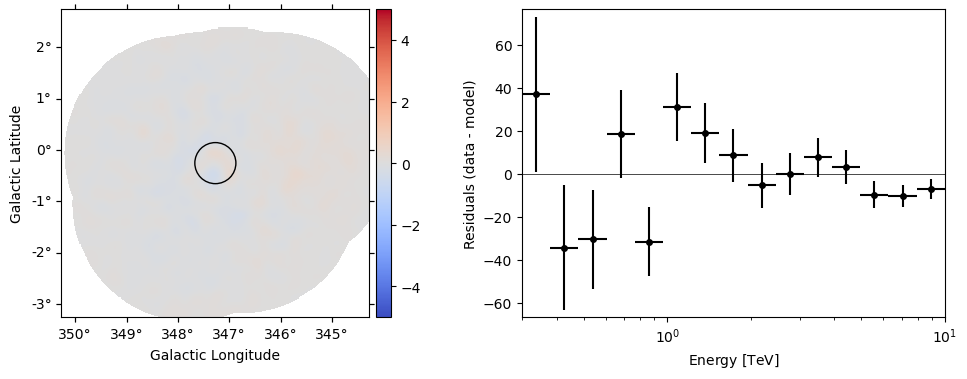

In [43]:
region = CircleSkyRegion(center=target_position, radius=0.4 * u.deg)
stacked.plot_residuals(kwargs_spectral={"region": region});

### 6 - Plot the fitted spectrum

Making a butterfly plot

The SpectralModel component can be used to produce a, so-called, butterfly plot showing the envelope of the model taking into account parameter uncertainties:


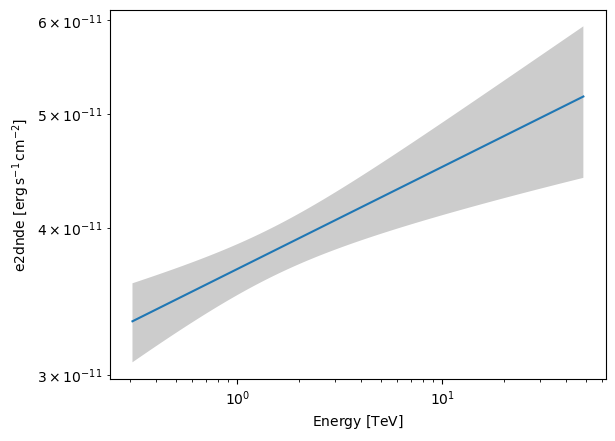

In [44]:
spec = sky_model.spectral_model
energy_bounds = [0.3, 50] * u.TeV
spec.plot(energy_bounds=energy_bounds, sed_type="e2dnde")
ax = spec.plot_error(energy_bounds=energy_bounds, sed_type="e2dnde")

### 7 - Computing flux points

We can now compute some flux points using the ~gammapy.estimators.FluxPointsEstimator.

Besides the list of datasets to use, we must provide it the energy intervals on which to compute flux points as well as the model component name.


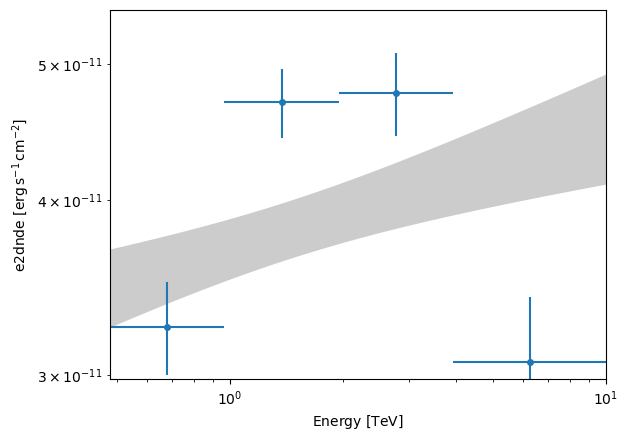

In [45]:
from gammapy.estimators import FluxPointsEstimator
energy_edges = [0.5, 1, 2, 4, 10] * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges, source="rxj")
flux_points = fpe.run(datasets=[stacked])
ax = spec.plot_error(energy_bounds=[0.3, 20] * u.TeV, sed_type="e2dnde")
flux_points.plot(ax=ax, sed_type="e2dnde");

## More advanced 

### 8 - Source significance

What is the TS-based significance of this source? You can estimate it by comparing the model likelihood without (null hypothesis) and with the source model

In [46]:
from gammapy.modeling import select_nested_models

sky_model.spatial_model.lon_0.frozen = False
sky_model.spatial_model.lat_0.frozen = False
sky_model.spatial_model.sigma.frozen = False

sky_model.spectral_model.amplitude.frozen = False
sky_model.spectral_model.index.frozen = True

datasets = Datasets([stacked])
datasets.models =  Models([sky_model, bkg_model])

parameters = [sky_model.spectral_model.amplitude, sky_model.spatial_model.lon_0, sky_model.spatial_model.lat_0, sky_model.spatial_model.sigma]
null_values = [0, sky_model.spatial_model.lon_0.value, sky_model.spatial_model.lat_0.value, sky_model.spatial_model.sigma.value]
n_free_parameters = len(sky_model.parameters.free_parameters)

results = select_nested_models(datasets=datasets,
                                 parameters=parameters,
                                 null_values=null_values,
                                 n_sigma=-np.inf,
                                 n_free_parameters=n_free_parameters
                                )

In [47]:
from gammapy.stats.utils import ts_to_sigma
ts_to_sigma(results['ts'], df=n_free_parameters)

32.33628407174553

### 9 - Does the source exhibit energy-dependent morphology? 

A dedicated estimator has been implemented to answer to this question, EnergyDependentMorphologyEstimator